In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.sparse.linalg import norm

In [2]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_lasso import *
from DZFW_lasso import *
from IZFW_lasso import *

## Load data

In [12]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [13]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [7]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [8]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
w0 = np.zeros(d)
print(f"w0: {w0}")

w0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Deterministic Gradient Free Frank Wolfe

In [ ]:
%%time

# Lipschitz constant 
L = 3

fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=100)

In [ ]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

In [ ]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy") # data from colab (NOT NORMALIZED)
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n
f_star = np.min(f_d)

In [ ]:
F_eval = np.abs(f_d - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("dZFW")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

## Stochastic Gradient Free Frank Wolfe

In [30]:
%%time
fpred, f, w, mean, t, loss, f_values = stochasticZFW(F, d, w0, method = "IRDSA1", r=1, T=10, eps=1e-10)

Loss evaluation at time 1:	0.0246347

Loss evaluation at time 2:	0.0242958

Loss evaluation at time 3:	0.0210544

Loss evaluation at time 4:	0.0081856

Loss evaluation at time 5:	0.0039112

Loss evaluation at time 6:	0.0170652

Loss evaluation at time 7:	0.0094145

Loss evaluation at time 8:	0.0093013

Loss evaluation at time 9:	0.0066842

Loss evaluation at time 10:	0.0057219

CPU times: user 1min 37s, sys: 5.23 s, total: 1min 42s
Wall time: 27.8 s


In [31]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.0010340795040677865

F(w_pred) = 0.010661740927335196

F(w) = 0.016383607814956107

w = [0. 0. 0. ... 0. 0. 0.]

average w = [0. 0. 0. ... 0. 0. 0.]

T = 10


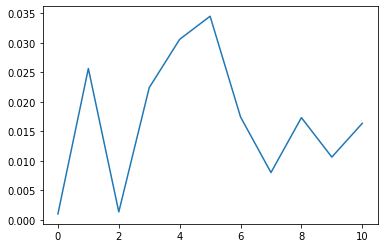

In [32]:
plt.plot(f_values - F(w_star))

In [ ]:
f_values

In [ ]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

In [ ]:
F_eval = np.abs(f_stochm6 - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6)")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

In [ ]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

In [ ]:
F_eval = np.abs(f_stochm6 - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("sZFW with RDSA (m=1)")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates

In [31]:
%%time 

# setting parameters
L = 0.1
D = 10000 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100)
B = 1

fpred, f, w, mean, t, loss, f_values = IZFW(F, d, w0, L, B, r = 1, T = 10, eps = 1e-3)

Loss evaluation at time 1:	1.3791321

Loss evaluation at time 2:	0.4522815



KeyboardInterrupt: 

In [33]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 259.05091757836703

F(w) = 259.0508674789056

w = [2.59069832e-12 3.76718696e-12 2.88669335e-14 ... 2.71115010e-12
 3.13978697e-13 1.17696342e-12]

average w = [3.24063977e-09 4.71227999e-09 3.61089254e-11 ... 3.39130988e-09
 3.92748103e-10 1.47223411e-09]

T = 10000


In [ ]:
f_inex = np.load('../Data/results/function_IZFW_lasso.npy') # data from cluster
F_eval = np.abs(f_inex/n - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("IZFW with m(t) < n")
plt.grid()

In [ ]:
F_eval = np.abs(f_inex/n - np.min(f_inex/n))
plt.plot(F_eval)
plt.yscale("log")
plt.title("IZFW with m(t) < n")
plt.grid()

# Test on artificial dataset


In [3]:
def CreateDataSet(n, d, s):
    """
    n rows, d features, s sparsity level
    """
    np.random.seed(1007)
    s = np.int(d * s)
    X = np.random.randn(n,d) 
    pn = int(s/2)
    w_s = np.concatenate((np.ones(pn), -np.ones(pn), np.zeros(d-2*pn)))
    w_s = w_s/np.sum(np.abs(w_s))
    epsilon = 0.01*np.random.rand(n) # noise
    y = X @ w_s + epsilon
    return X, y, w_s, epsilon

In [4]:
X, y, w_star, noise = CreateDataSet(n = 100, d = 1000, s = 0.05)

In [5]:
np.sum(np.abs(w_star))

1.0

In [6]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")
print(f"f* = {F(w_star):.8f}")

Space Dimensions
d: 1000
n: 100


NameError: name 'F' is not defined

In [26]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

indeces = np.random.randint(low = 0, high = d-1, size = int(d/2))
w0[indeces] = int(0)
print(f"w0: {w0[:10]}, {np.count_nonzero(w0)} elements different from zero")

w0: [0.00000000e+00 6.94725184e-05 5.32349094e-07 6.23650766e-05
 0.00000000e+00 2.30543109e-05 0.00000000e+00 4.58801767e-05
 6.46670184e-05 0.00000000e+00], 595 elemts different from zero


## Deterministic Gradient Free Frank Wolfe

In [27]:
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)

In [35]:
%%time

# Lipschitz constant 

L = 2/X.shape[0] * np.linalg.norm(X.T @ X)

fpred, f, w, mean, t, loss, f_valuesd = detZFW(F, L, d, w0, T=1000, eps = 1e-8)

Loss evaluation at time 1:	0.2869688

Loss evaluation at time 2:	0.2624069

Loss evaluation at time 3:	0.0283229

Loss evaluation at time 4:	0.0363124

Loss evaluation at time 5:	0.0025483

Loss evaluation at time 6:	0.0077457

Loss evaluation at time 7:	0.0023958

Loss evaluation at time 8:	0.0006643

Loss evaluation at time 9:	0.0035124

Loss evaluation at time 10:	0.0015967

Loss evaluation at time 11:	0.0036494

Loss evaluation at time 12:	0.0023726

Loss evaluation at time 13:	0.0035014

Loss evaluation at time 14:	0.0010940

Loss evaluation at time 15:	0.0018221

Loss evaluation at time 16:	0.0000485

Loss evaluation at time 17:	0.0014287

Loss evaluation at time 18:	0.0023645

Loss evaluation at time 19:	0.0007307

Loss evaluation at time 20:	0.0011386

Loss evaluation at time 21:	0.0002368

Loss evaluation at time 22:	0.0005389

Loss evaluation at time 23:	0.0001284

Loss evaluation at time 24:	0.0002807

Loss evaluation at time 25:	0.0003878

Loss evaluation at time 26:	0.0004

In [30]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376754

F(w_pred) = 0.0001572218539217139

F(w) = 0.00015722510307105125

w = [ 0.00000000e+00  2.19669002e-09  1.68326407e-11  1.97195588e-09
  0.00000000e+00  6.60848742e-03  0.00000000e+00  1.45071070e-09
  3.69948981e-03  0.00000000e+00  0.00000000e+00  4.74515930e-10
  7.92202773e-10  1.42048216e-09  2.24498830e-03  2.63663869e-09
  2.16029669e-09  0.00000000e+00  0.00000000e+00  9.68511210e-10
  0.00000000e+00  7.27249923e-03  0.00000000e+00  2.29969919e-10
  2.68046521e-09  2.71493511e-09  1.97556516e-09  4.74539905e-10
 -2.08688928e-03 -5.47018276e-03  0.00000000e+00 -2.44419149e-02
  0.00000000e+00  1.36442998e-09 -4.64807437e-03  0.00000000e+00
 -2.40624782e-02  2.54195325e-10  1.46595254e-09 -4.90103080e-03
  0.00000000e+00  2.70281978e-09 -3.41491178e-03  6.71313771e-10
 -6.98792133e-03  0.00000000e+00 -1.07190286e-02  2.33145447e-09
  1.47518269e-09  1.43269332e-10  0.00000000e+00 -7.11439890e-03
  0.00000000e+00  2.30688825e-09  2.00583715e-

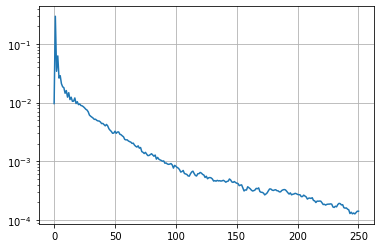

In [36]:
plt.plot(f_valuesd - F(w_star))
plt.yscale("log")
plt.grid()

## Stochastic Gradient Free Frank Wolfe

In [37]:
%%time
fpred, f, w, mean, t, loss, f_valuess = stochasticZFW(F, d, w0, method = "IRDSA2", r=1, T=1000, eps=1e-8)

Loss evaluation at time 1:	0.0204991

Loss evaluation at time 2:	0.0089793

Loss evaluation at time 3:	0.0046565

Loss evaluation at time 4:	0.0021214

Loss evaluation at time 5:	0.0061588

Loss evaluation at time 6:	0.0030151

Loss evaluation at time 7:	0.0026727

Loss evaluation at time 8:	0.0143263

Loss evaluation at time 9:	0.0103020

Loss evaluation at time 10:	0.0060904

Loss evaluation at time 11:	0.0049963

Loss evaluation at time 12:	0.0023320

Loss evaluation at time 13:	0.0068838

Loss evaluation at time 14:	0.0057417

Loss evaluation at time 15:	0.0022328

Loss evaluation at time 16:	0.0048797

Loss evaluation at time 17:	0.0033407

Loss evaluation at time 18:	0.0016281

Loss evaluation at time 19:	0.0007241

Loss evaluation at time 20:	0.0020742

Loss evaluation at time 21:	0.0019329

Loss evaluation at time 22:	0.0016399

Loss evaluation at time 23:	0.0029881

Loss evaluation at time 24:	0.0006431

Loss evaluation at time 25:	0.0033496

Loss evaluation at time 26:	0.0004

In [33]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376754

F(w_pred) = 0.0004891270654847369

F(w) = 0.0004856260687057259

w = [ 7.16413676e-03  3.83275507e-09  1.83438158e-03  3.44064198e-09
  0.00000000e+00  6.56122708e-04  0.00000000e+00  2.53118044e-09
  3.56763866e-09  4.91401460e-03 -6.99468798e-04  8.27928987e-10
  1.38222470e-09  5.98193845e-03  0.00000000e+00  6.97503064e-04
  1.68069922e-03  0.00000000e+00  6.02922400e-04  1.68984528e-09
  0.00000000e+00  7.01833534e-03  0.00000000e+00 -2.22647413e-04
  1.86197091e-03  4.73698212e-09 -9.45726159e-05  8.27970818e-10
  2.19463447e-09  0.00000000e+00 -6.67155310e-03 -1.49745433e-03
  0.00000000e+00  2.38063900e-09 -2.00777100e-03  0.00000000e+00
 -1.85014066e-03  4.43516570e-10 -1.69054456e-03 -2.94762062e-03
  0.00000000e+00  4.71584346e-09 -8.72858246e-04  1.17129920e-09
 -1.11067764e-02  0.00000000e+00  0.00000000e+00  4.06789028e-09
  2.57387884e-09  2.49974395e-10  6.33659621e-03 -7.30993022e-04
  0.00000000e+00  1.39897785e-04  3.49975757e-0

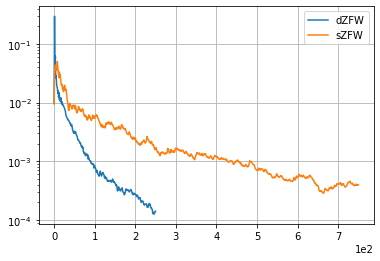

In [59]:
plt.plot(f_valuesd - F(w_star))
plt.plot(f_valuess - F(w_star))
plt.legend(('dZFW', 'sZFW'))
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

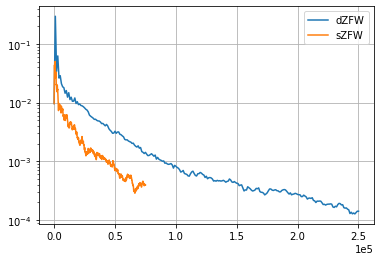

In [62]:
plt.plot(range(1, 251*d, d), f_valuesd - F(w_star))
plt.plot(range(0, 750*100+1, 100), f_valuess - F(w_star))
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW'))
plt.grid()


## Zeroth order stochastic accelerated gradient method with Inexact updates

In [16]:
%%time 

# setting parameters
B=1   
L = 0.1
D=10000 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100)
B = 1

fpred, f, w, mean, t, loss, f_values = IZFW(F, d, w0, L, B, r = 1, T = 100, eps = 1e-10)

Loss evaluation at time 1:	0.0033957

Loss evaluation at time 2:	0.0109985

Loss evaluation at time 3:	0.0243772

Loss evaluation at time 4:	0.0081644

Loss evaluation at time 5:	0.0111005

Loss evaluation at time 6:	0.0007956

Loss evaluation at time 7:	0.0070983

Loss evaluation at time 8:	0.0025161

Loss evaluation at time 9:	0.0052832

Loss evaluation at time 10:	0.0028060



KeyboardInterrupt: 

In [13]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 0.02130706510578931

F(w) = 0.021661137710379596

w = [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0